<a href="https://colab.research.google.com/github/prinzessinmarlenifee/SenseCap/blob/main/SenseCap_v4-2_dataaugment_global_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Global Model with Data Augmentation

##short overview



Saving model and checkpoints for Zwischenspeicherung

CSV-sensor data sheet
1.   wrist
2.   seat
3.  head
-> 3 Sensoren, 9 Spalten
-> checkt erste und zweite Zeile für header (da unterschiedlich)

*   hot encoding for labeling
 Action, Pedaling, Resting, Pushing

 Summary at end with


*   test accuracy
*   confusion matrix

-> saved and stored in Drive as csv and png file





all data is stored in Drive

##Model Choice


✅ Teil 2: Ist CNN + LSTM eine gute Architektur für IMU-Zeitreihendaten?

Ja, das ist eine bewährte Kombination – besonders bei IMU-Daten (z. B. Accelerometer/Gyroscope), weil:
🔎 Warum CNN?

    Erkennt lokale Muster in kurzen Zeitfenstern (z. B. Bewegungsphasen)

    Spart Rechenzeit, da es weniger Parameter hat als ein reines LSTM

🔁 Warum LSTM?

    Erkennt zeitliche Abhängigkeiten (z. B. Bewegungsabfolgen)

    Ideal für sequentielle Daten, wie du sie hast

✅ Alternativen oder Erweiterungen

Falls du später mehr Leistung brauchst:

    Bidirectional LSTM → besser für symmetrische Bewegungsabfolgen

    Residual CNN Blocks → für tiefere Netzwerke

    Transformer → wenn du sehr viele Daten und lange Sequenzen hast

##Setup und Vorbereitung

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Trouble-shooting google drive

In [ ]:
#lölscht colab cache
!rm -rf /content/drive


rm: cannot remove '/content/drive/MyDrive': Operation canceled
rm: cannot remove '/content/drive/.file-revisions-by-id': Operation canceled
rm: cannot remove '/content/drive/.shortcut-targets-by-id': Operation canceled
rm: cannot remove '/content/drive/.Trash-0': Directory not empty
rm: cannot remove '/content/drive/.Encrypted/MyDrive': Operation canceled
rm: cannot remove '/content/drive/.Encrypted/.shortcut-targets-by-id': Operation canceled


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


KeyboardInterrupt: 

In [3]:
import os
if os.path.ismount('/content/drive'):
    print("Drive ist schon gemountet – wird entmountet.")


drive.mount('/content/drive')


Drive ist schon gemountet – wird entmountet.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Packeages and setup

In [4]:
#import packages
import os
import json
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf

layers = tf.keras.layers
models = tf.keras.models


In [5]:
# --- PARAMETER ---
sampling_rate = 60       # 60 Hz nach SDI-Algorithmus
window_size = 60         # 1 Sekunde = 60 Frames
step_size = 30           # 50% Überlappung

# Basisverzeichnis (sollte die 18 Session-Ordner enthalten)
base_dir = '/content/drive/MyDrive/ML-MTB-Modell/IMU-Sessions/'


#Sessions einlesen

In [6]:
#prints founded sessions below
session_dirs = sorted([
    d for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d))
])
print(f"Gefundene Sessions: {len(session_dirs)} -> {session_dirs}")


Gefundene Sessions: 12 -> ['Session_01', 'Session_02', 'Session_03', 'Session_05', 'Session_06', 'Session_07', 'Session_09', 'Session_10', 'Session_11', 'Session_12', 'Session_13', 'Session_14']


Fuktionen zum LAbel-Parsing und Datei finden

In [7]:
# 5.1 parse_hot_labels: Liest die _hot.json-Datei ein, erstellt für jeden Frame ein Label
def parse_hot_labels(json_path, total_frames):
    with open(json_path, 'r') as f:
        data = json.load(f)
    entries = data['button_presses'].strip().split(';')

    label_changes = []
    for entry in entries:
        if ':' in entry:
            label, frame = entry.strip().split(':')
            label = label.strip()
            # Korrigiere evtl. "Peadling" → "Pedaling"
            if label.lower() == 'peadling':
                label = 'Pedaling'
            label_changes.append((int(frame.strip()), label))

    frame_labels = ['Unknown'] * total_frames
    for i, (start_frame, label) in enumerate(label_changes):
        end_frame = label_changes[i + 1][0] if i + 1 < len(label_changes) else total_frames
        for f in range(start_frame, min(end_frame, total_frames)):
            frame_labels[f] = label
    return frame_labels

# 5.2 find_sensor_file: Findet CSV-Datei, deren Name mit dem Prefix beginnt (Head_, Wrist_, Seat_)
def find_sensor_file(folder, prefix):
    for f in os.listdir(folder):
        if f.lower().startswith(prefix.lower()):
            return os.path.join(folder, f)
    raise FileNotFoundError(f"❌ Keine Datei mit Prefix '{prefix}' in {folder} gefunden.")

# 5.3 find_hot_file: Findet JSON-Datei, deren Name auf "_hot.json" endet
def find_hot_file(folder):
    for f in os.listdir(folder):
        if f.lower().endswith('_hot.json'):
            return os.path.join(folder, f)
    raise FileNotFoundError(f"❌ Keine Datei mit Suffix '_hot.json' in {folder} gefunden.")


# 6. Fensterung für drei Sensoren kombinieren

In [8]:
def window_data_multiple_sensors(head_data, wrist_data, seat_data, frame_labels):
    X_windows, y_windows = [], []
    total_frames = len(frame_labels)

    # Annahme: head_data, wrist_data, seat_data haben alle dieselbe Anzahl Zeilen = total_frames
    for start in range(0, total_frames - window_size + 1, step_size):
        end = start + window_size

        win_h = head_data[start:end]    # (window_size, 6)
        win_w = wrist_data[start:end]
        win_s = seat_data[start:end]
        window = np.concatenate([win_h, win_w, win_s], axis=1)  # → (window_size, 18)

        label_window = frame_labels[start:end]
        dominant_label = Counter(label_window).most_common(1)[0][0]
        if dominant_label == 'Unknown':
            continue

        X_windows.append(window)
        y_windows.append(dominant_label)

    return np.array(X_windows), np.array(y_windows)


#7. Daten einlesen und Fenster / Labels erzeugen
→ Nach Ausführung siehst du für jede Session etwa: “→ 153 Fenster, 3 Klassen” etc.

In [9]:
#Vorbereitung
sessions_X = []
sessions_y = []
valid_sessions = []  # <- neue Liste! mit nur valid sessions
skipped_sessions = []

#features definieren:
features = ['Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']

#Funktionen für Daten einlesen
def smart_feature_filter(df):
    # alles lowercase und leerzeichenfrei vergleichen
    keep = [col for col in df.columns if any(kw in col.lower() for kw in ['euler', 'acc', 'gyr'])]
    return df[keep]

def print_csv_headers(path, label):
    with open(path, 'r') as f:
        lines = f.readlines()
    print(f"\n📋 {label} → Datei: {os.path.basename(path)}")
    print("   Zeile 0:", lines[0].strip())
    print("   Zeile 1:", lines[1].strip())


def inspect_sensor_csv(path):
    df = pd.read_csv(path, sep=',', skiprows=1)
    df.columns = df.columns.str.strip()
    print(f"📊 {os.path.basename(path)}: {df.shape[1]} Spalten")
    print("   → Spaltennamen:", df.columns.tolist())




def load_sensor_csv(path):
  import csv

  # Erste zwei Zeilen lesen
  with open(path, 'r') as f:
      reader = csv.reader(f)
      first_line = next(reader)
      second_line = next(reader)

  # Prüfen ob erste Zeile ein Header ist (z. B. mit bekannten Schlüsselwörtern)
  first_line_str = ",".join(first_line).lower()
  if any(kw in first_line_str for kw in ['euler', 'acc', 'gyr']):
      skip = 0
  else:
      skip = 1

  # Einlesen
  df = pd.read_csv(path, sep=',', skiprows=skip)
  df.columns = df.columns.str.strip()

  # Features filtern
  df = smart_feature_filter(df)

  # Numerisch umwandeln und NaN behandeln
  df = df.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)

  return df.values

  print(f"🔍 {os.path.basename(path)}: Header {'erste Zeile' if skip==0 else 'zweite Zeile'}")




# --- Hauptschleife ---
for sess_dir in session_dirs:
    print(f"\n📂 Lade Session: {sess_dir}")
    session_path = os.path.join(base_dir, sess_dir)


    # 7.1 Sensor-Dateien finden
    head_path  = find_sensor_file(session_path, 'Head_')
    wrist_path = find_sensor_file(session_path, 'Wrist_')
    seat_path  = find_sensor_file(session_path, 'Seat_')

    # 7.2 Hot-JSON-Datei finden
    hot_path = find_hot_file(session_path)

    inspect_sensor_csv(head_path)
    inspect_sensor_csv(wrist_path)
    inspect_sensor_csv(seat_path)


    #print csv-heads for debugging & checking (oben definierte function print_csv_headers)
    #print_csv_headers(head_path, 'Head')
    #print_csv_headers(wrist_path, 'Wrist')
    #print_csv_headers(seat_path, 'Seat')




    # 7.3 IMU-Daten laden
    #funktion um imu laden
    #aktuelles Problem: header in der zweiten Zeile, seperator ',' , erkennt nur zwei spalten beim einlesen



    head_data  = load_sensor_csv(head_path)
    wrist_data = load_sensor_csv(wrist_path)
    seat_data  = load_sensor_csv(seat_path)




    print(f"📊 Sensorlängen: Head={head_data.shape}, Wrist={wrist_data.shape}, Seat={seat_data.shape}")

    #expected_features = 27  # 3 Sensoren × 9 Features (oben definiert)
   # if X_win.shape[1:] != (window_size, expected_features):
    #      print(f"⚠️ Session {sess_dir} hat Format {X_win.shape[1:]}, wird übersprungen.")
     #     skipped_sessions.append(sess_dir)
      #    continue



    #7.4 Labels laden
    total_frames = min(head_data.shape[0], wrist_data.shape[0], seat_data.shape[0])
    frame_labels = parse_hot_labels(hot_path, total_frames)



    # 7.5 Sicherheitskürzung (später optional mit synch.json ersetzen)
    head_data  = head_data[:total_frames]
    wrist_data = wrist_data[:total_frames]
    seat_data  = seat_data[:total_frames]
    frame_labels = frame_labels[:total_frames]


    # 7.6 Fensterung & Label-Zuweisung
    X_win, y_win = window_data_multiple_sensors(head_data, wrist_data, seat_data, frame_labels)

    # 5. Gültigkeit prüfen
    if len(X_win) == 0:
        print(f"⚠️  Session {sess_dir} übersprungen – keine gültigen Fenster.")
        skipped_sessions.append(sess_dir)
        continue

    expected_features = 27  # oder dynamisch aus den Daten

    if X_win.shape[1:] != (window_size, expected_features):
        print(f"⚠️  Session {sess_dir} hat Format {X_win.shape[1:]}, wird übersprungen.")
        skipped_sessions.append(sess_dir)
        continue


        # 6. Speichern
    sessions_X.append(X_win)
    sessions_y.append(y_win)
    valid_sessions.append(sess_dir)
    print(f"✅ Session {sess_dir}: {len(X_win)} Fenster, {len(np.unique(y_win))} Klassen")

# --- Zusammenfassung ---
print("\n✅ Verwendete Sessions:")
for idx, sess in enumerate(valid_sessions):
    print(f"  {sess}: {sessions_X[idx].shape}")

if skipped_sessions:
    print("\n⛔️ Übersprungene Sessions:")
    for s in skipped_sessions:
        print(f"  {s}")











📂 Lade Session: Session_01
📊 Head_D422CD00563B_20230713_082527.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed: 11']
📊 Wrist_D422CD004550_20230713_082527.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed: 11']
📊 Seat_D422CD00456D_20230713_082527.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed: 11']
📊 Sensorlängen: Head=(60077, 9), Wrist=(60078, 9), Seat=(60075, 9)
✅ Session Session_01: 1997 Fenster, 3 Klassen

📂 Lade Session: Session_02
📊 Head_D422CD00563B_20230713_085629.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed:

/tmp/ipython-input-9-2824237205.py:25: DtypeWarning: Columns (5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=',', skiprows=1)


📊 Wrist_D422CD004550_20230727_073528.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed: 11']


/tmp/ipython-input-9-2824237205.py:25: DtypeWarning: Columns (5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=',', skiprows=1)


📊 Seat_D422CD00456D_20230727_073528.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed: 11']


/tmp/ipython-input-9-2824237205.py:50: DtypeWarning: Columns (5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=',', skiprows=skip)
/tmp/ipython-input-9-2824237205.py:50: DtypeWarning: Columns (5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=',', skiprows=skip)


📊 Sensorlängen: Head=(65763, 9), Wrist=(65763, 9), Seat=(65763, 9)
✅ Session Session_11: 2181 Fenster, 4 Klassen

📂 Lade Session: Session_12
📊 Head_D422CD004576_20230801_075834.csv: 12 Spalten
   → Spaltennamen: ['0', '416010770', '-4.522172451019287', '48.04213333129883', '21.0351619720459', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '']
📊 Wrist_D422CD004550_20230801_075834.csv: 12 Spalten
   → Spaltennamen: ['0', '532295258', '-42.42717361450195', '45.996009826660156', '-55.192440032958984', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '']
📊 Seat_D422CD00456D_20230801_075834.csv: 11 Spalten
   → Spaltennamen: ['0', '409881162', '2202328491210930', '-6035955047607420', '-8357672119140620', '0.00000000000000', '0.00000000000000.1', '0.00000000000000.2', '0.00000000000000.3', '0.00000000000000.4', '0.00000000000000.5']
📊 Sensorlängen: Head=(59523, 9), Wrist=(59524, 9), Seat=(59514, 9)
✅ Session Session_12: 1967 Fenster, 4 Klassen

📂 Lade Session: Session_13
📊 Head_D422CD004576_20230802_080027.c

🧠 Dann ist deine Fensterform:

    3 Sensoren × 9 Spalten = 27 Features
    → Fenster-Shape: (window_size, 27) = (60, 27)


Euler_X, Euler_Y, Euler_Z


Acc_X, Acc_Y, Acc_Z

Gyr_X, Gyr_Y, Gyr_Z

→ = 9 physikalisch sinnvolle Spalten pro Sensor

#8. Global Model: Training and Evaluation




Schritt-für-Schritt Erklärung

  **1. Daten zusammenführen**

    Alle Sessions werden zu einem großen Datensatz verbunden, damit das Modell aus allen Beispielen lernt.

 **2. Label-Encoding**


    Die Labels (z.B. verschiedene Aktivitäten) werden in numerische Werte umgewandelt, da das Modell nur mit Zahlen arbeitet.

 **3. Trainings- und Validierungs-Split**

    Der Datensatz wird in Training (90%) und Validation (10%) aufgeteilt. Validation wird genutzt, um das Modell während des Trainings zu überprüfen.

  **4. Modell erstellen**

    Das Modell kombiniert Convolutional Layers (um lokale Muster in den Zeitreihen zu erkennen) mit LSTM (um zeitliche Abhängigkeiten zu lernen). Dropout wird eingesetzt, um Überanpassung zu vermeiden.

  **5. Checkpoint Callback**

    Während des Trainings werden Modelle nach jeder Epoche gespeichert (nur die besten, basierend auf Validierungsleistung).

  **6. Training**
  
    Das Modell lernt über 50 Epochen, wobei Trainings- und Validierungsdaten genutzt werden.

  **7. Finales Modell speichern**

    Das finale Modell wird nach dem Training gespeichert,
    um es später laden und nutzen zu können.

  **8. Evaluation auf Validierungsdaten**

    Das Modell wird auf den Validation-Daten getestet,
    um die Genauigkeit zu ermitteln.

  **9.  Vorhersagen erzeugen**

    Die Wahrscheinlichkeiten für jede Klasse werden ermittelt und in Klassen umgewandelt (höchste Wahrscheinlichkeit = Vorhersage).

  **10.  Labels prüfen**

    Nur die tatsächlich in den Validierungsdaten vorhandenen Klassen werden für den Bericht verwendet.

 **11.  Classification Report**

    Präzision, Recall, F1-Score und Support für jede Klasse werden ausgegeben — wichtige Kennzahlen für die Modellgüte.

  **12.  Confusion Matrix**

    Visualisiert die Fehler des Modells,
    zeigt welche Klassen oft verwechselt werden.


##📘 Was ist ein Docstring?

Ein Docstring ist eine mehrzeilige Zeichenkette, die direkt nach einer Funktion, Klasse oder Moduldefinition steht.
Er dient als Dokumentation, die später mit help() oder in IDEs angezeigt wird


Beispiel:

def addiere(a, b):
    """
    Diese Funktion addiert zwei Zahlen und gibt das Ergebnis zurück.
    
    Parameter:
    a (int): Erste Zahl
    b (int): Zweite Zahl

    Rückgabe:
    int: Summe von a und b
    """
    return a + b

* So wird der Docstring verwendet:

help(addiere)

* 📋 Ausgabe:

  Help on function addiere in module __main__:

  addiere(a, b)
    Diese Funktion addiert zwei Zahlen und gibt das Ergebnis zurück.
    
    Parameter:
    a (int): Erste Zahl
    b (int): Zweite Zahl

    Rückgabe:
    int: Summe von a und b

In [10]:
# prompt: how many action, resting, pedaling and action labeled sections are there?

label_counts = Counter(y_win)
print("\n📋 Summary of Labels in the last processed session:")
for label, count in label_counts.items():
    print(f"  {label}: {count} sections")

# To get the total count across ALL valid sessions:
all_labels = [label for session_labels in sessions_y for label in session_labels]
total_label_counts = Counter(all_labels)

print("\n📋 Total Summary of Labels across ALL valid sessions:")
for label, count in total_label_counts.items():
    print(f"  {label}: {count} sections")

# Specifically for the requested labels:
print("\nRequested Label Counts:")
print(f"  Action: {total_label_counts.get('Action', 0)} sections")
print(f"  Resting: {total_label_counts.get('Resting', 0)} sections")
print(f"  Pedaling: {total_label_counts.get('Pedaling', 0)} sections")
# Assuming 'action labeled sections' refers to the 'Action' label
# If it's a distinct label, you'd need to add it to the Counter logic.
# Based on the code, 'Action' seems to be the relevant label.
print(f"  action labeled sections: {total_label_counts.get('Action', 0)} sections")


📋 Summary of Labels in the last processed session:
  Resting: 1165 sections
  Pedaling: 46 sections
  Action: 567 sections
  Pushing: 91 sections

📋 Total Summary of Labels across ALL valid sessions:
  Resting: 12573 sections
  Pedaling: 728 sections
  Action: 7656 sections
  Pushing: 2251 sections

Requested Label Counts:
  Action: 7656 sections
  Resting: 12573 sections
  Pedaling: 728 sections
  action labeled sections: 7656 sections


In [26]:
# prompt: downsample so there are a maximum of 5000 sections for each label. Action should remain with its original count

# Separate data by label
data_by_label = {}
for i in range(len(all_labels)):
  label = all_labels[i]
  if label not in data_by_label:
    data_by_label[label] = []
  # Find which session and index the window belongs to
  current_window_idx = 0
  found = False
  for session_idx, session_X in enumerate(sessions_X):
    num_windows_in_session = len(session_X)
    if i >= current_window_idx and i < current_window_idx + num_windows_in_session:
      index_in_session = i - current_window_idx
      data_by_label[label].append((session_X[index_in_session], label))
      found = True
      break
    current_window_idx += num_windows_in_session
  if not found:
      print(f"Warning: Could not find session data for overall index {i} with label {label}")


# Downsample labels (except 'Action')
downsampled_data = []
max_sections = 5000

for label, data in data_by_label.items():
    if label != 'Action' and len(data) > max_sections:
        print(f"Downsampling label '{label}' from {len(data)} to {max_sections} sections.")
        # Randomly sample
        indices = np.random.choice(len(data), max_sections, replace=False)
        downsampled_data.extend([data[i] for i in indices])
    else:
        print(f"Keeping all {len(data)} sections for label '{label}'.")
        downsampled_data.extend(data)

# Shuffle the downsampled data
np.random.shuffle(downsampled_data)

# Separate features (X) and labels (y) from downsampled data
X_combined_downsampled = np.array([item[0] for item in downsampled_data])
y_combined_downsampled = np.array([item[1] for item in downsampled_data])

print(f"\nTotal sections after downsampling: {len(X_combined_downsampled)}")
downsampled_label_counts = Counter(y_combined_downsampled)
print("\n📋 Summary of Labels after downsampling:")
for label, count in downsampled_label_counts.items():
    print(f"  {label}: {count} sections")



Downsampling label 'Resting' from 13303 to 5000 sections.
Keeping all 3698 sections for label 'Pedaling'.
Keeping all 9479 sections for label 'Action'.
Keeping all 2251 sections for label 'Pushing'.

Total sections after downsampling: 20428

📋 Summary of Labels after downsampling:
  Resting: 5000 sections
  Pushing: 2251 sections
  Pedaling: 3698 sections
  Action: 9479 sections



Anzahl der Klassen: 4
Klassennamen: ['Action' 'Pedaling' 'Pushing' 'Resting']

Trainingsdaten: (14354, 60, 27) Fenster, (14354,) Labels
Validierungsdaten: (1595, 60, 27) Fenster, (1595,) Labels

Label distribution in training set:
  Resting: 4500
  Pedaling: 3328
  Action: 4500
  Pushing: 2026

Label distribution in validation set:
  Resting: 500
  Pedaling: 370
  Pushing: 225
  Action: 500

Trainingsdaten nach Reshape: (14354, 60, 27, 1)
Validierungsdaten nach Reshape: (1595, 60, 27, 1)

CNN Output shape before reshape for LSTM: (None, 13, 5, 64)
Reshaping to (None, 65, 64) for LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 58, 25, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 29, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 29, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 27, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 5, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 13, 5, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 65, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 65, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 65, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,460 (669.77 KB)

 Trainable params: 171,460 (669.77 KB)

 Non-trainable params: 0 (0.00 B)


Starting training on downsampled data...
Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.3011 - loss: 1.3625
Epoch 1: val_accuracy improved from -inf to 0.36489, saving model to /content/drive/MyDrive/ML-MTB-Modell/checkpoints/global_model_best.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 103s 216ms/step - accuracy: 0.3011 - loss: 1.3625 - val_accuracy: 0.3649 - val_loss: 1.3110
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.3948 - loss: 1.2883
Epoch 2: val_accuracy improved from 0.36489 to 0.42382, saving model to /content/drive/MyDrive/ML-MTB-Modell/checkpoints/global_model_best.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.3948 - loss: 1.2883 - val_accuracy: 0.4238 - val_loss: 1.2366
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.4183 - loss: 1.2301
Epoch 3: val_accuracy improved from 0.42382 to 0.44953, saving model to /content/drive/MyDrive/ML-MTB-Modell/checkpoints/global_model_best.keras
449/449 ━━━━━━━━━━━━━

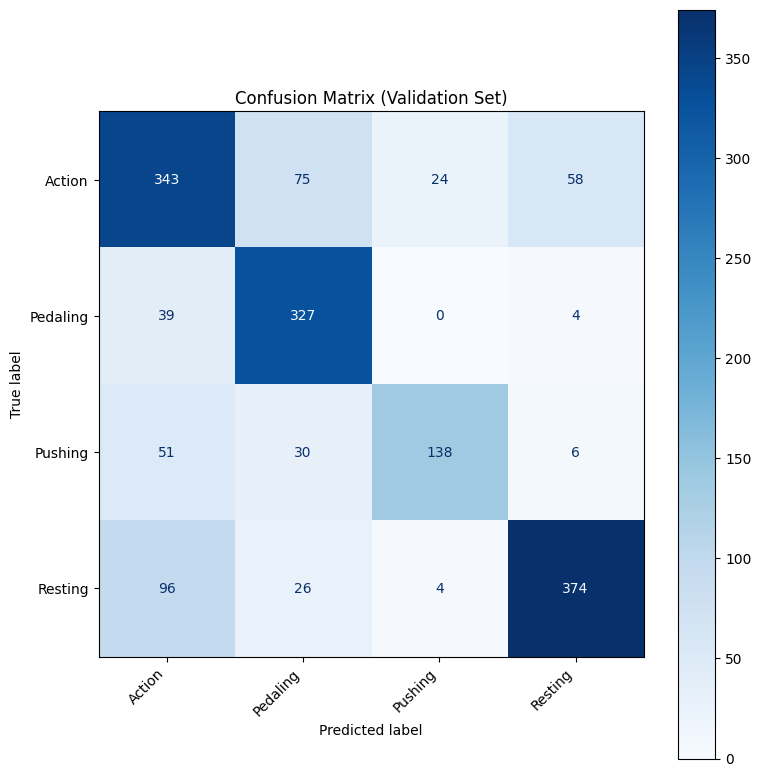

In [27]:
# prompt: use the downsampled data and train the model from the next code cell on it

# Ensure X_downsampled and y_downsampled are defined from the previous cell
if 'X_downsampled' in locals() and 'y_downsampled' in locals():

    # 2. Label-Encoding
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_downsampled)
    num_classes = len(label_encoder.classes_)
    class_names = label_encoder.classes_
    print(f"\nAnzahl der Klassen: {num_classes}")
    print(f"Klassennamen: {class_names}")

    # 3. Trainings- und Validierungs-Split (using the downsampled data)
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(
        X_downsampled, y_encoded, test_size=0.1, random_state=42, stratify=y_encoded
    )

    print(f"\nTrainingsdaten: {X_train.shape} Fenster, {y_train.shape} Labels")
    print(f"Validierungsdaten: {X_val.shape} Fenster, {y_val.shape} Labels")

    # Check class distribution in train and validation sets
    print("\nLabel distribution in training set:")
    train_counts = Counter(label_encoder.inverse_transform(y_train))
    for label, count in train_counts.items():
        print(f"  {label}: {count}")

    print("\nLabel distribution in validation set:")
    val_counts = Counter(label_encoder.inverse_transform(y_val))
    for label, count in val_counts.items():
        print(f"  {label}: {count}")

    # Reshape data for CNN input (add channel dimension)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)

    print(f"\nTrainingsdaten nach Reshape: {X_train.shape}")
    print(f"Validierungsdaten nach Reshape: {X_val.shape}")


    # 4. Modell erstellen
    def build_cnn_lstm_model(input_shape, num_classes):
        model = models.Sequential()

        # CNN Layers
        model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.25))

        model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.25))

        # Reshape for LSTM - flatten the output of CNN layers
        # Calculate the dimensions after CNN and MaxPooling
        cnn_output_shape = model.output_shape
        timesteps = cnn_output_shape[1] * cnn_output_shape[2] # Combine height and width dimensions
        features = cnn_output_shape[3]
        print(f"\nCNN Output shape before reshape for LSTM: {cnn_output_shape}")
        print(f"Reshaping to (None, {timesteps}, {features}) for LSTM")

        model.add(layers.Reshape((timesteps, features)))


        # LSTM Layers
        model.add(layers.LSTM(units=128, return_sequences=True)) # Return sequences for next LSTM layer
        model.add(layers.Dropout(0.25))
        model.add(layers.LSTM(units=64)) # No return sequences for the last LSTM layer
        model.add(layers.Dropout(0.25))

        # Dense Layers
        model.add(layers.Dense(units=64, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(units=num_classes, activation='softmax'))

        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    # Get the input shape (window_size, num_features, channels)
    # After reshaping, the input shape to the first Conv2D layer is (window_size, 27, 1)
    input_shape = (window_size, X_train.shape[2], 1)
    model = build_cnn_lstm_model(input_shape, num_classes)

    model.summary()


    # 5. Checkpoint Callback
    # Define the checkpoint path
    checkpoint_path = "/content/drive/MyDrive/ML-MTB-Modell/checkpoints/global_model_best.keras"

    # Create checkpoint callback
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_best_only=True,  # Save only the best model based on the monitored metric
        monitor='val_accuracy', # Metric to monitor (validation accuracy)
        mode='max',           # Mode for the monitor ('max' because we want to maximize accuracy)
        verbose=1             # Print messages when a checkpoint is saved
    )

    # Optional: Early Stopping to prevent overfitting and save training time
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', # Monitor validation loss
        patience=10,        # Number of epochs with no improvement after which training will be stopped.
        mode='min',         # Mode for the monitor ('min' because we want to minimize loss)
        restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity.
        verbose=1
    )


    # 6. Training
    epochs = 50
    batch_size = 32 # You can adjust this

    print("\nStarting training on downsampled data...")

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[model_checkpoint_callback, early_stopping_callback] # Add the callbacks here
    )

    print("\nTraining finished.")

    # Load the best model weights after training (due to restore_best_weights in EarlyStopping)
    # If EarlyStopping wasn't used, you'd typically load the best model from the checkpoint path
    # best_model = models.load_model(checkpoint_path)
    # For this setup with restore_best_weights=True, 'model' already holds the best weights.
    final_model = model

    # 7. Finales Modell speichern (optional, if not using checkpoints directly)
    # If you want to save the final state of the model (which should be the best one
    # if early stopping with restore_best_weights is used), you can save it again.
    # final_model_path = "/content/drive/MyDrive/ML-MTB-Modell/global_model_final.keras"
    # final_model.save(final_model_path)
    # print(f"Final model saved to: {final_model_path}")


    # 8. Evaluation auf Validierungsdaten
    print("\nEvaluating the best model on validation data...")
    val_loss, val_accuracy = final_model.evaluate(X_val, y_val, verbose=0)
    print(f"\nValidation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")

    # 9. Vorhersagen erzeugen
    y_pred_probs = final_model.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Decode predicted labels back to original names
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_val_labels = label_encoder.inverse_transform(y_val)

    # 10. Labels prüfen (Ensure all classes are present in the report)
    # Get all possible class names
    all_possible_labels = label_encoder.classes_


    # 11. Classification Report
    print("\nClassification Report:")
    print(classification_report(y_val_labels, y_pred_labels, labels=all_possible_labels, zero_division=0))

    # 12. Confusion Matrix
    cm = confusion_matrix(y_val_labels, y_pred_labels, labels=all_possible_labels)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_possible_labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title('Confusion Matrix (Validation Set)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Optional: Save the confusion matrix plot
    # cm_plot_path = "/content/drive/MyDrive/ML-MTB-Modell/confusion_matrix.png"
    # fig.savefig(cm_plot_path)
    # print(f"Confusion Matrix plot saved to: {cm_plot_path}")

    # Optional: Save classification report to a file
    # report_path = "/content/drive/MyDrive/ML-MTB-Modell/classification_report.csv"
    # report_dict = classification_report(y_val_labels, y_pred_labels, labels=all_possible_labels, output_dict=True, zero_division=0)
    # report_df = pd.DataFrame(report_dict).transpose()
    # report_df.to_csv(report_path)
    # print(f"Classification report saved to: {report_path}")


else:
    print("Downsampled data (X_downsampled, y_downsampled) not found. Please run the previous cell.")

In [28]:
# prompt: save the trained model under content/drive/MyDrive/ML-MTB-Modell/ML-Model_trained/SenseCap_Model_v42_augment_factor220250607-163310.keras/final_models_global/

import datetime

# Define the directory path
output_dir = '/content/drive/MyDrive/ML-MTB-Modell/ML-Model_trained/SenseCap_Model_v42_augment_factor220250607-163310.keras/final_models_global/'

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Generate a timestamp for the filename
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Define the model filename
model_filename = f"global_model_{timestamp}.keras"

# Construct the full path to save the model
full_model_path = os.path.join(output_dir, model_filename)

# Save the final trained model
# Assuming 'final_model' is the model object you want to save from the previous cell
if 'final_model' in locals():
    final_model.save(full_model_path)
    print(f"\nFinal model saved to: {full_model_path}")
else:
    print("\nModel 'final_model' not found. Please ensure the model was trained successfully.")


Final model saved to: /content/drive/MyDrive/ML-MTB-Modell/ML-Model_trained/SenseCap_Model_v42_augment_factor220250607-163310.keras/final_models_global/global_model_20250630-133110.keras


#Code

In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils.multiclass import unique_labels
import random
import time
timestamp = time.strftime("%Y%m%d-%H%M%S")

# 💾 Speicherpfade anlegen
checkpoint_dir = "/content/drive/MyDrive/mtb_project/checkpoints_global"
final_model_dir = "/content/drive/MyDrive/mtb_project/final_models_global"
report_dir = "/content/drive/MyDrive/mtb_project/reports_global"
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(final_model_dir, exist_ok=True)
os.makedirs(report_dir, exist_ok=True)

#Data Augmentation

def augment_time_series_multiclass(X, y, augment_factor=3, jitter_std=0.015, scale_range=(0.85, 1.15),
                                   permute_segments=3, apply_mixup=False, seed=42):
    """
    Führt Data Augmentation für multiklassige Zeitreihen durch.

    Args:
        X (np.array): Zeitreihendaten (N, T, F)
        y (np.array): Labels (N,)
        augment_factor (int): Wie viele zusätzliche augmentierte Samples pro Original (z. B. 2x = verdreifacht)
        jitter_std (float): Standardabweichung für Jittering (z. B. 0.01)
        scale_range (tuple): Min/Max Faktor für Scaling (z. B. (0.9, 1.1))
        permute_segments (int): Anzahl Segmente für Shuffle (z. B. 3)
        apply_mixup (bool): Ob Mixup verwendet werden soll (optional)
        seed (int): Random-Seed für Reproduzierbarkeit

    Returns:
        X_aug, y_aug: augmentierte Daten
    """
    np.random.seed(seed)
    random.seed(seed)

    N, T, F = X.shape
    X_aug = []
    y_aug = []

    def jitter(x):
        return x + np.random.normal(loc=0., scale=jitter_std, size=x.shape)

    def scale(x):
        factor = np.random.uniform(*scale_range)
        return x * factor

    def permute(x):
        segs = np.array_split(x, permute_segments)
        np.random.shuffle(segs)
        return np.concatenate(segs, axis=0)

    def mixup(x1, x2, y1, y2):
        alpha = np.random.beta(0.4, 0.4)
        x_mix = alpha * x1 + (1 - alpha) * x2
        # Label bleibt einfach y1 oder y2 – einfacher Ansatz
        return x_mix, y1 if np.random.rand() < 0.5 else y2

    for i in range(N):
        for _ in range(augment_factor):
            x_aug = X[i]

            # Transformationen
            if np.random.rand() < 0.5:
                x_aug = jitter(x_aug)
            if np.random.rand() < 0.5:
                x_aug = scale(x_aug)
            if np.random.rand() < 0.3:
                x_aug = permute(x_aug)

            if apply_mixup and np.random.rand() < 0.3:
                idx2 = np.random.randint(0, N)
                x_aug, y_mix = mixup(x_aug, X[idx2], y[i], y[idx2])
                y_aug.append(y_mix)
            else:
                y_aug.append(y[i])

            X_aug.append(x_aug)

    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)

    # Zusammenführen
    X_combined = np.concatenate([X, X_aug])
    y_combined = np.concatenate([y, y_aug])

    return X_combined, y_combined




# 1️⃣ Sessions zusammenführen (dieser Teil muss mit deinen Daten ergänzt werden!)
# Beispiel:
X_all = np.concatenate(sessions_X)
y_all = np.concatenate(sessions_y)

# 2️⃣ Labels encoden
le = LabelEncoder()
y_all_enc = le.fit_transform(y_all)


# joblib.dump(le, "/content/drive/MyDrive/mtb_project/label_encoder.pkl") #speicherung der labels für Auswertung später


# 3️⃣ Train/Val-Split
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all_enc, test_size=0.1, random_state=42, stratify=y_all_enc
)

# 4️⃣ Augmentieren – auf Original-Labels
y_train_original = le.inverse_transform(y_train)
X_aug, y_aug = augment_time_series_multiclass(X_train, y_train_original)
y_aug_enc = le.transform(y_aug)

# 🔀 Kombinieren
X_train_combined = np.concatenate([X_train, X_aug])
y_train_combined = np.concatenate([y_train, y_aug_enc])

# 5️⃣ Modell bauen
model = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=X_train.shape[1:]),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Dense(100, activation='relu'),
    layers.Dense(len(le.classes_), activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 6️⃣ Callback für Checkpoints
checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "global_epoch_{epoch:02d}.keras"),
    save_best_only=True, save_weights_only=False, verbose=1
)

# 7️⃣ Training
history = model.fit(
    X_train_combined, y_train_combined,
    validation_data=(X_val, y_val),
    epochs=50, batch_size=64,
    callbacks=[checkpoint_cb]
)

# 8️⃣ Speichern des finalen Modells
model.save(os.path.join(final_model_dir, "global_final_augment_factor2.keras"))

# 9️⃣ Evaluation
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"\n✅ Validation Accuracy: {val_acc:.2f}")

# 🔮 Vorhersagen
y_pred_probs = model.predict(X_val, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# 📊 Report + Matrix
labels_present = unique_labels(y_val, y_pred_classes)
report_text = classification_report(
    y_val, y_pred_classes,
    labels=labels_present,
    target_names=[le.classes_[i] for i in labels_present]
)
print("\n📄 Classification Report:\n")
print(report_text)

# 💾 Speichern als Text
with open(os.path.join(report_dir, "global_model_augmentf2_classification_report{timestamp}.txt"), "w") as f:
    f.write(report_text)

# 📈 Confusion Matrix
cm = confusion_matrix(y_val, y_pred_classes, labels=labels_present)
disp = ConfusionMatrixDisplay(cm, display_labels=[le.classes_[i] for i in labels_present])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix – Global Model Augmentf2 Validation")

# 💾 Speichern als PNG
plt.savefig(os.path.join(report_dir, "global_model_confusion_matrix_augmentfactor2{timestamp}.png"))
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyboardInterrupt: 

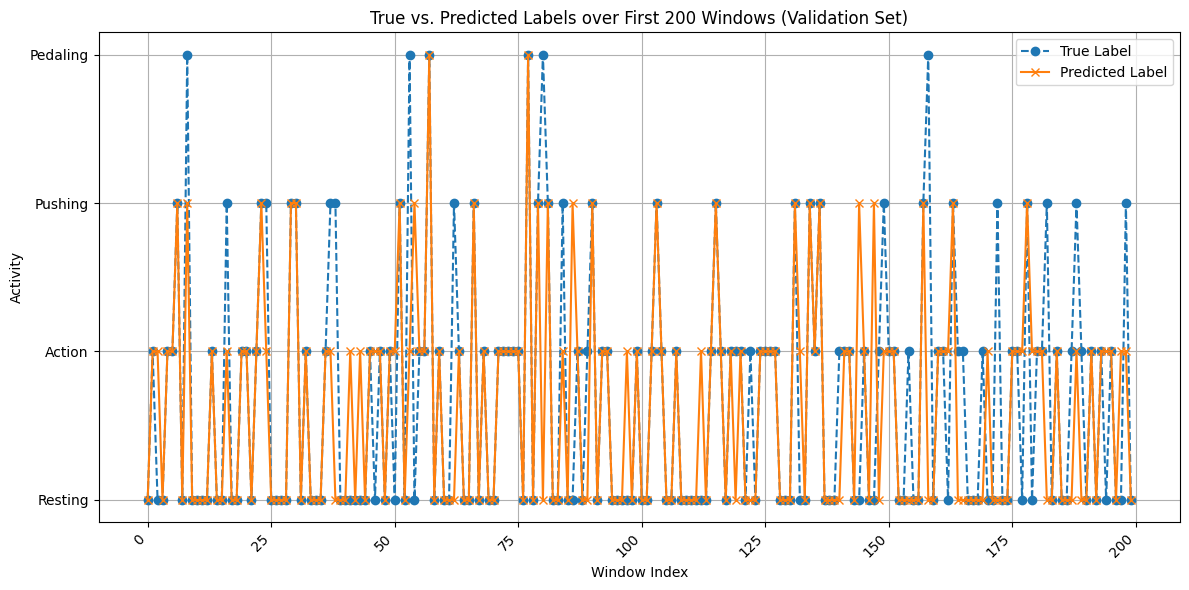

In [ ]:
# prompt: plot the labels against the prediction over time for the first 200 windows

plt.figure(figsize=(12, 6))
plt.plot(le.inverse_transform(y_val[:200]), label='True Label', marker='o', linestyle='--')
plt.plot(le.inverse_transform(y_pred_classes[:200]), label='Predicted Label', marker='x', linestyle='-')
plt.title('True vs. Predicted Labels over First 200 Windows (Validation Set)')
plt.xlabel('Window Index')
plt.ylabel('Activity')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#Code 2 - Model train with all augmentation factors

Hier kommt ein sauberes Trainings-Skript, das für alle gewünschten augment_factor-Werte deine Modelle trainiert und speichert

So läuft das:

    Für jeden augment_factor wird separat trainiert

    Modelle landen in /final_models_global/global_aug_factor_X.keras

    LabelEncoder wird einmal gespeichert für die spätere Analyse

    Du kannst danach dein Analyse-Notebook von oben starten und die Ergebnisse bequem vergleichen

In [ ]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import joblib

# Speicherorte anpassen
checkpoint_dir = "/content/drive/MyDrive/mtb_project/checkpoints_global"
final_model_dir = "/content/drive/MyDrive/mtb_project/final_models_global"
report_dir = "/content/drive/MyDrive/mtb_project/reports_global"
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(final_model_dir, exist_ok=True)
os.makedirs(report_dir, exist_ok=True)

# Deine augment_time_series_multiclass Funktion hier rein (oder importieren)

# 1. Daten laden (deine Sessions zusammenführen)
X_all = np.concatenate(sessions_X)
y_all = np.concatenate(sessions_y)

# 2. Labels encoden
le = LabelEncoder()
y_all_enc = le.fit_transform(y_all)

# LabelEncoder speichern
joblib.dump(le, os.path.join(final_model_dir, "label_encoder.pkl"))

# 3. Train/Val-Split
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all_enc, test_size=0.1, random_state=42, stratify=y_all_enc
)

# 4. Augmentierungsfaktoren zum Testen
augment_factors = [0, 1, 2, 3]

for factor in augment_factors:
    print(f"\n🎯 Training mit augment_factor={factor} ...")

    if factor > 0:
        # Labels vor der Augmentation zurückkonvertieren
        y_train_orig = le.inverse_transform(y_train)
        X_aug, y_aug = augment_time_series_multiclass(
            X_train, y_train_orig,
            augment_factor=factor,
            jitter_std=0.01,
            scale_range=(0.9, 1.1),
            permute_segments=3,
            apply_mixup=True
        )
        y_aug_enc = le.transform(y_aug)

        # Kombinieren
        X_train_combined = np.concatenate([X_train, X_aug])
        y_train_combined = np.concatenate([y_train, y_aug_enc])
    else:
        X_train_combined = X_train
        y_train_combined = y_train

    # Modell bauen
    model = models.Sequential([
        layers.Conv1D(64, 3, activation='relu', input_shape=X_train.shape[1:]),
        layers.Conv1D(64, 3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        layers.LSTM(64),
        layers.Dropout(0.3),
        layers.Dense(100, activation='relu'),
        layers.Dense(len(le.classes_), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Checkpoint Callback
    checkpoint_cb = ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, f"global_aug_factor_{factor}_epoch_{{epoch:02d}}.keras"),
        save_best_only=True, save_weights_only=False, verbose=1
    )

    # Trainieren
    history = model.fit(
        X_train_combined, y_train_combined,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        callbacks=[checkpoint_cb]
    )

    # Bestes Modell speichern (letztes oder bestes aus Checkpoints)
    model.save(os.path.join(final_model_dir, f"global_aug_factor_{factor}.keras"))

print("\n✅ Alle Modelle trainiert und gespeichert!")



🎯 Training mit augment_factor=0 ...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5110 - loss: 1.0639
Epoch 1: val_loss improved from inf to 0.96390, saving model to /content/drive/MyDrive/mtb_project/checkpoints_global/global_aug_factor_0_epoch_01.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.5113 - loss: 1.0635 - val_accuracy: 0.5816 - val_loss: 0.9639
Epoch 2/50
 88/327 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.5435 - loss: 0.9967

KeyboardInterrupt: 

#🧾 Zusammenfassung Modeltraining
##📊 1. Durchschnittliche Accuracy über alle Sessions:

In [ ]:
#📊 1. Durchschnittliche Accuracy über alle Sessions:

mean_acc = np.mean(all_accuracies)
print("\n📈 Zusammenfassung:")
for i, acc in enumerate(all_accuracies):
    print(f"  Session {i+1}: Accuracy = {acc:.2f}")
print(f"\n✅ Durchschnittliche Test-Accuracy über alle Sessions: {mean_acc:.2f}")


NameError: name 'all_accuracies' is not defined

##📁 2. CSV speichern (falls nicht schon vorhanden):

In [ ]:
#📁 2. CSV speichern (falls nicht schon vorhanden):

import pandas as pd

df_summary = pd.DataFrame(accuracy_summary)
df_summary['Session'] = [f"Session_{i+1}" for i in range(len(all_accuracies))]
df_summary.to_csv("/content/drive/MyDrive/mtb_project/session_accuracy_report.csv", index=False)
print("✅ Bericht gespeichert unter: session_accuracy_report.csv")


✅ Bericht gespeichert unter: session_accuracy_report.csv


In [ ]:
os.makedirs("/content/drive/MyDrive/mtb_project/reports", exist_ok=True)


# 🧾 Zusammenfassung nach dem Training:

Nach der Schleife kannst du am Ende folgendes hinzufügen, um einen Bericht zu erzeugen:

📊 Bonus: CSV speichern (optional)

In [ ]:

# Durchschnittliche Accuracy über alle Sessions
mean_acc = np.mean(all_accuracies)
print("\n📈 Zusammenfassung:")
for i, acc in enumerate(all_accuracies):
    print(f"  Session {i+1}: Accuracy = {acc:.2f}")
print(f"\n✅ Durchschnittliche Test-Accuracy über alle Sessions: {mean_acc:.2f}")



#📊 Bonus: CSV speichern (optional)

import pandas as pd

summary = {'Session': [], 'Accuracy': []}
for i, acc in enumerate(all_accuracies):
    summary['Session'].append(f"Session_{i+1}")
    summary['Accuracy'].append(acc)

df_summary = pd.DataFrame(summary)
df_summary.to_csv("session_accuracy_report.csv", index=False)
print("📁 Bericht gespeichert als session_accuracy_report.csv")




NameError: name 'all_accuracies' is not defined

#💾 II. Modell speichern & später wieder laden (z. B. nach Training)

##🔐 Speichern mit TensorFlow/**Keras**

In [ ]:
# Nach dem Training:
#speichert mit timestamp
#model.save("SenseCap_Eventdetection_Model.keras")  # speichert nur in colab kurzzeitig
import time
timestamp = time.strftime("%Y%m%d-%H%M%S")
model.save(f"/content/drive/MyDrive/ML-MTB-Modell/ML-Model_trained/SenseCap_Model_v42_augment_factor2{timestamp}.keras")



##🔄 Laden

Das speichert das gesamte Modell inkl. Architektur, Gewichten und Optimizer-Zustand –exakt da weitermachen, wo man aufgehört hast.

In [ ]:


from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/ML-MTB-Modell/ML-Model_trained/SenseCap_Eventdetection_Model1.keras")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 24 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
all_accuracies = []

for i in range(len(test_sessions_X)):
    X_test = test_sessions_X[i]
    y_test = test_sessions_y[i]

    _, acc = model.evaluate(X_test, y_test, verbose=0)
    all_accuracies.append(acc)


NameError: name 'test_sessions_X' is not defined

In [ ]:

# Durchschnittliche Accuracy über alle Sessions
mean_acc = np.mean(all_accuracies)
print("\n📈 Zusammenfassung:")
for i, acc in enumerate(all_accuracies):
    print(f"  Session {i+1}: Accuracy = {acc:.2f}")
print(f"\n✅ Durchschnittliche Test-Accuracy über alle Sessions: {mean_acc:.2f}")



#📊 Bonus: CSV speichern (optional)

import pandas as pd

summary = {'Session': [], 'Accuracy': []}
for i, acc in enumerate(all_accuracies):
    summary['Session'].append(f"Session_{i+1}")
    summary['Accuracy'].append(acc)

df_summary = pd.DataFrame(summary)
df_summary.to_csv("session_accuracy_report.csv", index=False)
print("📁 Bericht gespeichert als session_accuracy_report.csv")





📈 Zusammenfassung:

✅ Durchschnittliche Test-Accuracy über alle Sessions: nan
📁 Bericht gespeichert als session_accuracy_report.csv
